In [ ]:
# imports

import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt

import time

import copy

from IPython.utils import io

from keras.datasets import mnist

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Loading/Formatting Data

As per the homework specs, we will only be using 10k samples out of the total, with 1k samples for each class.

In [ ]:
# loading datasets
(train_X, train_y), (test_X, test_y) = mnist.load_data()

In [ ]:
# 60000 training samples
# 10000 testing samples

print('Training data shape: ' + str(train_X.shape))
print('Test data shape:  '  + str(test_X.shape))

Training data shape: (60000, 28, 28)
Test data shape:  (10000, 28, 28)


In [ ]:
# normalizing data
def normalize(data):
  return (data - np.mean(data)) / np.std(data)

train_X, test_X = train_X/255, test_X/255
train_X, test_X = normalize(train_X), normalize(test_X)

In [ ]:
X_train, y_train = [], []

# labels 0-9
for i in range(10):
  # all data of label i
  i_samples = np.where(train_y == i)[0]

  # get 1000 samples from each class
  indices = i_samples[np.random.randint(0, len(i_samples), size=1000)]

  X_train.extend(train_X[indices])
  y_train.extend(train_y[indices])

X_train = np.array(X_train)
y_train = np.array(y_train)

print('Training data shape: ' + str(X_train.shape))
print('Training labels shape:  '  + str(y_train.shape))

Training data shape: (10000, 28, 28)
Training labels shape:  (10000,)


In [ ]:
## Training dataloaders
inputs = Variable(torch.from_numpy(X_train))
labels = Variable(torch.from_numpy(y_train))

dataset = TensorDataset(inputs, labels)
train_dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

# Testing dataloader
inputs = Variable(torch.from_numpy(test_X))
labels = Variable(torch.from_numpy(test_y))

dataset = TensorDataset(inputs, labels)
test_dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

In [ ]:
def check_accuracy(test_loader: DataLoader, model: torch.nn.Module, device):
    num_correct = 0
    total = 0
    model.eval()

    with torch.no_grad():
        for data, labels in test_loader:
            data = data.float().to(device=device)
            labels = labels.float().to(device=device)

            predictions = model(data)

            num_correct += (predictions.argmax(1) == labels).sum()
            total += labels.size(0)

        print(f"Test Accuracy of the model: {float(num_correct)/float(total)*100:.2f}")

        return float(num_correct)/float(total)*100

# Testing Model
Testing Model with default parameters

In [ ]:
class NeuralNetwork(nn.Module):
  def __init__(self, hidden_num, dropout_rate=0.5):
      super(NeuralNetwork, self).__init__()
      self.flatten = nn.Flatten()
      self.output = nn.Sequential(
          nn.Linear(28*28, hidden_num),
          nn.Dropout(dropout_rate),
          nn.ReLU(),
          nn.Linear(hidden_num, hidden_num),
          nn.ReLU(),
          nn.Linear(hidden_num, 10)
      )
      self.softmax = nn.Softmax(1)

  def forward(self, x):
      x = self.flatten(x)
      logits = self.output(x)
      return self.softmax(logits)

hidden_num = 10

model = NeuralNetwork(hidden_num)
model.to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (output): Sequential(
    (0): Linear(in_features=784, out_features=10, bias=True)
    (1): Dropout(p=0.5, inplace=False)
    (2): ReLU()
    (3): Linear(in_features=10, out_features=10, bias=True)
    (4): ReLU()
    (5): Linear(in_features=10, out_features=10, bias=True)
  )
  (softmax): Softmax(dim=1)
)


In [ ]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4)

In [ ]:
loss_history = []
training_accuracy = []

for epoch in range(100):

    for id_batch, (x_batch, y_batch) in enumerate(train_dataloader):

      x_batch, y_batch = x_batch.to(device), y_batch.to(device)

      # Clear gradient buffers because we don't want any gradient from previous epoch to carry forward, dont want to cumulate gradients
      optimizer.zero_grad()

      # get output from the model, given the inputs
      outputs = model(x_batch.float())

      # get loss for the predicted output
      loss = criterion(outputs, y_batch)

      loss_history.append(loss.item())

      # get gradients w.r.t to parameters
      loss.backward()

      # update parameters
      optimizer.step()

    with io.capture_output() as captured:
      training_accuracy.append(check_accuracy(test_dataloader, model, device))

    if (epoch + 1) % 20 == 0:
      print('epoch {}, loss {}'.format(epoch + 1, loss.item()))

epoch 20, loss 1.7253642082214355
epoch 40, loss 1.6440303325653076
epoch 60, loss 1.551253318786621
epoch 80, loss 1.591598391532898
epoch 100, loss 1.7073220014572144


Test Accuracy of the model: 83.76


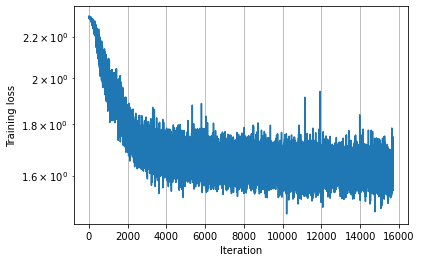

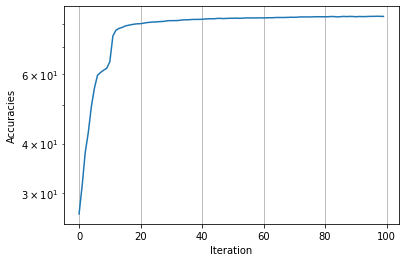

In [ ]:
# Final Test Accuracy
acc = check_accuracy(test_dataloader, model, device)

# Training Loss
plt.figure()
plt.semilogy(loss_history)    
plt.grid()
plt.xlabel('Iteration')
plt.ylabel('Training loss') 
plt.show()

# Training Accuracies
plt.figure()
plt.semilogy(training_accuracy)    
plt.grid()
plt.xlabel('Iteration')
plt.ylabel('Accuracies') 
plt.show()

# 2. Varying k and p parameters
Testing model with various k and p inputs.
*   **k** corresponds to: **number of hidden units**
*   **p** corresponds to: **dropout rate**


### Note: 

In Pytorch, p is defined as **"[the] probability of an element to be zeroed."**, which is the opposite interpretation to the homework. All analysis will be in accordance. 


## Testing with fixed p (no dropout regularization)

In our case, p = 0.0 is equivalent to no dropout.

Source: https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html 

---



In [ ]:
# only one loop since we are using a fixed p value
all_training_accuracies = []
all_test_accuracies = []
all_loss = []

for k in [1, 3, 5, 10, 15, 25, 40]:
  model = NeuralNetwork(k, dropout_rate=0.0)
  model.to(device)

  criterion = torch.nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4)

  print(f'Training Neural Net with {k} hidden units')

  loss_history = []
  training_accuracy = []

  for epoch in range(80):

      for id_batch, (x_batch, y_batch) in enumerate(train_dataloader):

        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        # Clear gradient buffers because we don't want any gradient from previous epoch to carry forward, dont want to cumulate gradients
        optimizer.zero_grad()

        # get output from the model, given the inputs
        outputs = model(x_batch.float())

        # get loss for the predicted output
        loss = criterion(outputs, y_batch)

        loss_history.append(loss.item())

        # get gradients w.r.t to parameters
        loss.backward()

        # update parameters
        optimizer.step()

      with io.capture_output() as captured:
        training_accuracy.append(check_accuracy(test_dataloader, model, device))
  
  # Final Test Accuracy
  acc = check_accuracy(test_dataloader, model, device)
  print()
    
  all_training_accuracies.append(training_accuracy)
  all_test_accuracies.append(acc)
  all_loss.append(loss_history)

Training Neural Net with 1 hidden units
Test Accuracy of the model: 9.58

Training Neural Net with 3 hidden units
Test Accuracy of the model: 61.32

Training Neural Net with 5 hidden units
Test Accuracy of the model: 75.12

Training Neural Net with 10 hidden units
Test Accuracy of the model: 83.09

Training Neural Net with 15 hidden units
Test Accuracy of the model: 91.32

Training Neural Net with 25 hidden units
Test Accuracy of the model: 92.43

Training Neural Net with 40 hidden units
Test Accuracy of the model: 92.28



Text(0, 0.5, 'Training Accuracy')

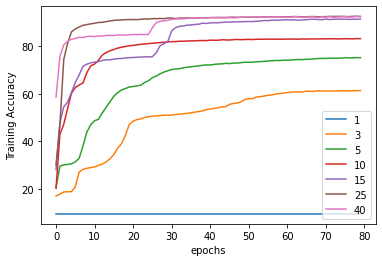

In [ ]:
plt.figure()
for line in all_training_accuracies:
  plt.plot(line)
  plt.legend(['1', '3', '5', '10', '15', '25', '40'])

plt.xlabel('epochs')
plt.ylabel('Training Accuracy')

Text(0.5, 1.0, '# hidden units vs. Test Accuracy')

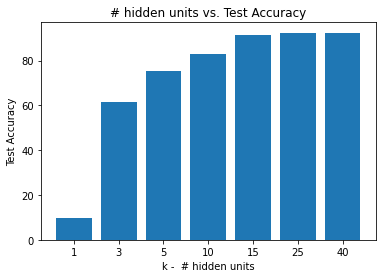

In [ ]:
plt.bar(['1', '3', '5', '10', '15', '25', '40'], all_test_accuracies)
plt.xlabel('k -  # hidden units')
plt.ylabel('Test Accuracy')
plt.title('# hidden units vs. Test Accuracy')

### Comments
Accuracy is highest at k = 25. It does seem that as k increases, the accuracy of the model generally improves, however there is most likely a cutoff point where the increase in complexity is no longer beneficial, as can be seen with k = 40.

## Testing with varying k and p


---



In [ ]:
all_training_accuracies = []
all_test_accuracies = []
all_loss = []

for k in [1, 3, 5, 10, 15, 25, 40]:
  p_accuracies = []
  p_test_acc = []
  p_loss = []

  print(f'Training Neural Net with {k} hidden units')

  for p in [0.1, 0.5, 1.0]:

    model = NeuralNetwork(k, p)
    model.to(device)

    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4)

    loss_history = []
    training_accuracy = []

    for epoch in range(80):

        for id_batch, (x_batch, y_batch) in enumerate(train_dataloader):

          x_batch, y_batch = x_batch.to(device), y_batch.to(device)

          # Clear gradient buffers because we don't want any gradient from previous epoch to carry forward, dont want to cumulate gradients
          optimizer.zero_grad()

          # get output from the model, given the inputs
          outputs = model(x_batch.float())

          # get loss for the predicted output
          loss = criterion(outputs, y_batch)

          loss_history.append(loss.item())

          # get gradients w.r.t to parameters
          loss.backward()

          # update parameters
          optimizer.step()

        with io.capture_output() as captured:
          training_accuracy.append(check_accuracy(test_dataloader, model, device))

    # Final Test Accuracy
    with io.capture_output() as captured:
      acc = check_accuracy(test_dataloader, model, device)
    p_test_acc.append(acc)
    p_accuracies.append(training_accuracy)
    p_loss.append(loss_history)

    print(f'\tdropout rate {p}: {acc}%')
    
  print()
  all_training_accuracies.append(p_accuracies)
  all_test_accuracies.append(p_test_acc)
  all_loss.append(p_loss)

Training Neural Net with 1 hidden units
	dropout rate 0.1: 22.7%
	dropout rate 0.5: 26.479999999999997%
	dropout rate 1.0: 19.56%

Training Neural Net with 3 hidden units
	dropout rate 0.1: 62.019999999999996%
	dropout rate 0.5: 64.13%
	dropout rate 1.0: 70.98%

Training Neural Net with 5 hidden units
	dropout rate 0.1: 74.72999999999999%
	dropout rate 0.5: 77.61%
	dropout rate 1.0: 71.73%

Training Neural Net with 10 hidden units
	dropout rate 0.1: 89.55%
	dropout rate 0.5: 90.36999999999999%
	dropout rate 1.0: 89.7%

Training Neural Net with 15 hidden units
	dropout rate 0.1: 91.03%
	dropout rate 0.5: 91.46%
	dropout rate 1.0: 91.86999999999999%

Training Neural Net with 25 hidden units
	dropout rate 0.1: 91.8%
	dropout rate 0.5: 83.89999999999999%
	dropout rate 1.0: 92.2%

Training Neural Net with 40 hidden units
	dropout rate 0.1: 84.34%
	dropout rate 0.5: 92.75999999999999%
	dropout rate 1.0: 92.75%



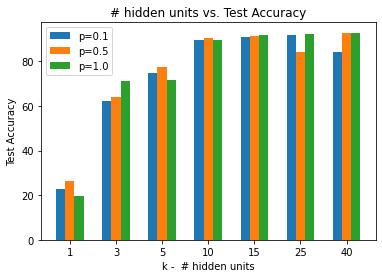

In [ ]:
x, ax = np.arange(7), [-0.2, 0, 0.2]

for i in range(3):
  p_accuracies = []
  for idx, accuracies_k in enumerate(all_training_accuracies):
    p_accuracies.append(accuracies_k[i][-1])
  # print(np.array(p_accuracies).shape, len(x), p_accuracies, x+ax[i])
  plt.bar(x+ax[i], p_accuracies, 0.2)

plt.xticks(x, ['1', '3', '5', '10', '15', '25', '40'])

plt.xlabel('k -  # hidden units')
plt.ylabel('Test Accuracy')
plt.title('# hidden units vs. Test Accuracy')
plt.legend(["p=0.1", "p=0.5", "p=1.0"])

The best test accuracy was achieved with 40 hidden units and a dropout rate of 0.5, although a dropout rate of 1.0 was very close. In this case, it seems that dropout was not completely necessary with 40 hidden units.

### Comments

1. What is the role of p on training accuracy?

> It seems that utilizing dropout generally increases the training accuracy of the model, although there does seem to be a fine line to tread when it comes to optimizing this parameter.

2. When p is smaller, is it easier to optimize or more difficult? 

> Given the documentation, when p is smaller that means the probability of an element to be zeroed becomes smaller. (It is stated differently in the homework, but we will go with this assumption). When p is smaller, then it becomes more difficult to optimize the modelm, hence generally a worse performance as seen in the figure above. 

3. Does dropout help with the test accuracy?

> In terms of the model's performance, it did help because the model did not overfit to the data.

#3. Adding Noise

In [ ]:
def add_noise(y, num_classes, percentage):

  noisy_y = copy.deepcopy(y)

  num_noisy = int(np.floor(percentage * len(y)))
  # select random indices
  indices = np.random.choice(range(len(y)), num_noisy, replace=False)

  # transform data
  for idx in indices:
    curr_label = y_train[idx]

    # get new label, must be different
    new_label = np.random.randint(0, num_classes)
    while new_label == curr_label:
      new_label = np.random.randint(0, num_classes)

    noisy_y[idx] = new_label

  return noisy_y

In [ ]:
# adding noise to labels
noisy_y = add_noise(y_train, num_classes=10, percentage=0.4)

print('Training labels shape (noise):  '  + str(noisy_y.shape))

Training labels shape (noise):  (10000,)


In [ ]:
## Training dataloaders
inputs = Variable(torch.from_numpy(X_train))
labels = Variable(torch.from_numpy(noisy_y))

dataset = TensorDataset(inputs, labels)
train_dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

# Testing dataloader
inputs = Variable(torch.from_numpy(test_X))
labels = Variable(torch.from_numpy(test_y))

dataset = TensorDataset(inputs, labels)
test_dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

In [ ]:
all_training_accuracies = []
all_test_accuracies = []
all_loss = []

for k in [1, 3, 5, 10, 15, 25, 40]:
  p_accuracies = []
  p_test_acc = []
  p_loss = []

  print(f'Training Neural Net with {k} hidden units')

  for p in [0.1, 0.5, 1.0]:

    model = NeuralNetwork(k, p)
    model.to(device)

    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4)

    loss_history = []
    training_accuracy = []

    for epoch in range(80):

        for id_batch, (x_batch, y_batch) in enumerate(train_dataloader):

          x_batch, y_batch = x_batch.to(device), y_batch.to(device)

          # Clear gradient buffers because we don't want any gradient from previous epoch to carry forward, dont want to cumulate gradients
          optimizer.zero_grad()

          # get output from the model, given the inputs
          outputs = model(x_batch.float())

          # get loss for the predicted output
          loss = criterion(outputs, y_batch)

          loss_history.append(loss.item())

          # get gradients w.r.t to parameters
          loss.backward()

          # update parameters
          optimizer.step()

        with io.capture_output() as captured:
          training_accuracy.append(check_accuracy(test_dataloader, model, device))

    # Final Test Accuracy
    with io.capture_output() as captured:
      acc = check_accuracy(test_dataloader, model, device)
    p_test_acc.append(acc)
    p_accuracies.append(training_accuracy)
    p_loss.append(loss_history)

    print(f'\tdropout rate {p}: {acc}%')
    
  print()
  all_training_accuracies.append(p_accuracies)
  all_test_accuracies.append(p_test_acc)
  all_loss.append(p_loss)

Training Neural Net with 1 hidden units
	dropout rate 0.1: 9.8%
	dropout rate 0.5: 9.8%
	dropout rate 1.0: 20.02%

Training Neural Net with 3 hidden units
	dropout rate 0.1: 27.279999999999998%
	dropout rate 0.5: 44.98%
	dropout rate 1.0: 62.519999999999996%

Training Neural Net with 5 hidden units
	dropout rate 0.1: 62.33%
	dropout rate 0.5: 75.36%
	dropout rate 1.0: 57.96%

Training Neural Net with 10 hidden units
	dropout rate 0.1: 86.1%
	dropout rate 0.5: 85.34%
	dropout rate 1.0: 80.14%

Training Neural Net with 15 hidden units
	dropout rate 0.1: 81.28999999999999%
	dropout rate 0.5: 88.09%
	dropout rate 1.0: 85.37%

Training Neural Net with 25 hidden units
	dropout rate 0.1: 89.02%
	dropout rate 0.5: 88.56%
	dropout rate 1.0: 88.75999999999999%

Training Neural Net with 40 hidden units
	dropout rate 0.1: 88.41%
	dropout rate 0.5: 88.74%
	dropout rate 1.0: 88.68%



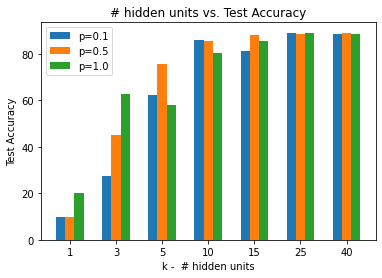

In [ ]:
x, ax = np.arange(7), [-0.2, 0, 0.2]

for i in range(3):
  p_accuracies = []
  for idx, accuracies_k in enumerate(all_training_accuracies):
    p_accuracies.append(accuracies_k[i][-1])
  # print(np.array(p_accuracies).shape, len(x), p_accuracies, x+ax[i])
  plt.bar(x+ax[i], p_accuracies, 0.2)

plt.xticks(x, ['1', '3', '5', '10', '15', '25', '40'])

plt.xlabel('k -  # hidden units')
plt.ylabel('Test Accuracy')
plt.title('# hidden units vs. Test Accuracy')
plt.legend(["p=0.1", "p=0.5", "p=1.0"])

1. How does noise change things? 

> Noise reduced the overall accuracy of the models by a significant portion. When comparing the highest accuracies from both steps 2 and 3, there was about a 5% decrease in accuracy.


2. For which setup dropout is more useful?

> Dropout seems to be more useful with noisy data, in the sense that it had a much more noticeable effect when applied in conjunction with noise. When comparing it to the models trained on clean data, when p was higher (probability of element to be 0d in PyTorch) those models did not perform much better, if at all, to the models with a lower p. 
